API: BUDY3YVLDT9HB0O7

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(os.path.join('HSM','stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])

In [4]:
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


In [5]:
df = df.sort_values("Date").reset_index(drop=True)

In [6]:
df["y_next"] = df["Close"].shift(-1)
df = df.dropna().reset_index(drop=True)

In [7]:
X = df[["Close"]].values
y = df["y_next"].values.reshape(-1,1)

In [8]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Función para crear secuencias (ventanas)
def create_sequences(X, y, window=50):
    xs, ys = [], []
    for i in range(len(X)-window):
        xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(xs), np.array(ys)

In [9]:
WINDOW = 50
X_seq, y_seq = create_sequences(X_scaled, y_scaled, WINDOW)

# Split temporal (80% train, 20% test)
split = int(len(X_seq)*0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [10]:
tf.random.set_seed(42)

model = models.Sequential([
    layers.Input(shape=(WINDOW, X_seq.shape[2])),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=2
)


Epoch 1/50
301/301 - 9s - 29ms/step - loss: 0.0017 - mae: 0.0219 - val_loss: 4.7766e-04 - val_mae: 0.0173
Epoch 2/50
301/301 - 6s - 20ms/step - loss: 8.6234e-04 - mae: 0.0164 - val_loss: 4.3298e-04 - val_mae: 0.0164
Epoch 3/50
301/301 - 11s - 36ms/step - loss: 7.1872e-04 - mae: 0.0150 - val_loss: 4.4612e-04 - val_mae: 0.0168
Epoch 4/50
301/301 - 6s - 20ms/step - loss: 6.7798e-04 - mae: 0.0152 - val_loss: 3.3880e-04 - val_mae: 0.0136
Epoch 5/50
301/301 - 7s - 23ms/step - loss: 6.3280e-04 - mae: 0.0148 - val_loss: 3.7156e-04 - val_mae: 0.0150
Epoch 6/50
301/301 - 7s - 23ms/step - loss: 5.8114e-04 - mae: 0.0145 - val_loss: 6.3844e-04 - val_mae: 0.0198
Epoch 7/50
301/301 - 7s - 22ms/step - loss: 6.2164e-04 - mae: 0.0153 - val_loss: 3.6692e-04 - val_mae: 0.0150
Epoch 8/50
301/301 - 7s - 22ms/step - loss: 5.4607e-04 - mae: 0.0144 - val_loss: 2.9589e-04 - val_mae: 0.0127
Epoch 9/50
301/301 - 7s - 23ms/step - loss: 5.4123e-04 - mae: 0.0147 - val_loss: 2.8797e-04 - val_mae: 0.0122
Epoch 10/50
3

In [19]:
from sklearn.metrics import root_mean_squared_error


y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

rmse = root_mean_squared_error(y_test_inv, y_pred)
mae = mean_absolute_error(y_test_inv, y_pred)
presicion = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}", f"Presicion: {presicion}%")

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 0.43, MAE: 0.31 Presicion: 2.4348065036127973%


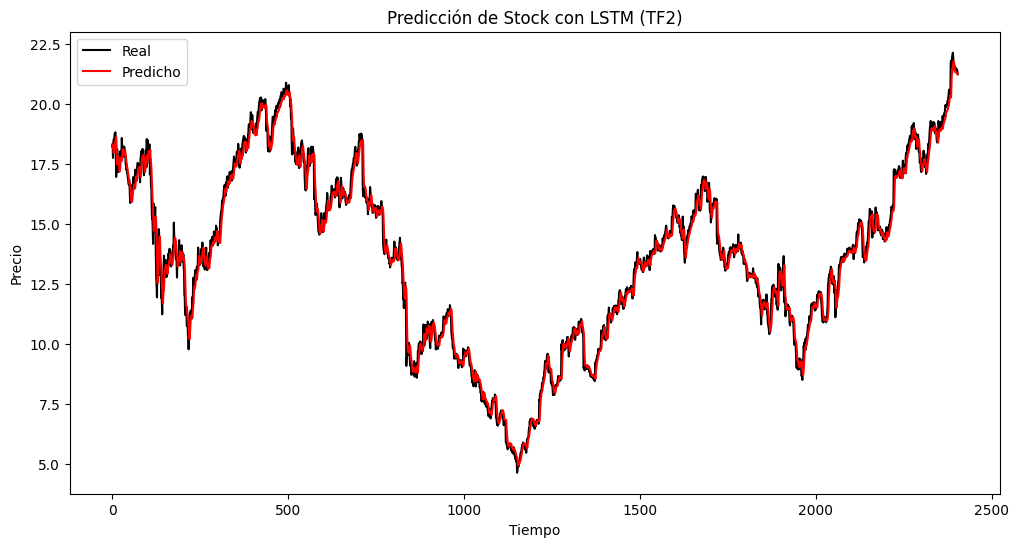

In [18]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Real", color="black")
plt.plot(y_pred, label="Predicho", color="red")
plt.title("Predicción de Stock con LSTM (TF2)")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.legend()
plt.show()